In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "data/hymenoptera_data/"
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), 
                                           data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
               batch_size=4, shuffle=True, num_workers=4) for x in ["train", "val"]}
dataset_sizes = {x : len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [5]:
dataloaders?

Type:        dict
String form: {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f01b44c0790>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f01b44bc0a0>}
Length:      2
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


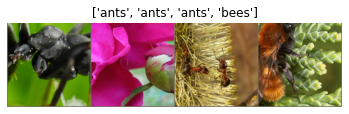

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0 , 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 15)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()         # set model to training mode
            else:
                model.eval()          # set model to validation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)           #returns max and location of max
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_ets = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler =lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
---------------
train Loss: 0.6645 Acc: 0.7418
val Loss: 0.4602 Acc: 0.8562

Epoch 1/24
---------------
train Loss: 0.4365 Acc: 0.8402
val Loss: 0.4793 Acc: 0.8693

Epoch 2/24
---------------
train Loss: 0.5301 Acc: 0.8320
val Loss: 0.3957 Acc: 0.8889

Epoch 3/24
---------------
train Loss: 0.4813 Acc: 0.7992
val Loss: 0.2266 Acc: 0.8889

Epoch 4/24
---------------
train Loss: 0.3872 Acc: 0.8402
val Loss: 0.3381 Acc: 0.8562

Epoch 5/24
---------------
train Loss: 0.4151 Acc: 0.8115
val Loss: 0.3473 Acc: 0.8627

Epoch 6/24
---------------
train Loss: 0.3728 Acc: 0.8484
val Loss: 0.2154 Acc: 0.9150

Epoch 7/24
---------------
train Loss: 0.3384 Acc: 0.8607
val Loss: 0.2229 Acc: 0.9281

Epoch 8/24
---------------
train Loss: 0.2737 Acc: 0.8730
val Loss: 0.2095 Acc: 0.9216

Epoch 9/24
---------------
train Loss: 0.3127 Acc: 0.8852
val Loss: 0.2396 Acc: 0.9085

Epoch 10/24
---------------
train Loss: 0.2806 Acc: 0.8975
val Loss: 0.1985 Acc: 0.9281

Epoch 11/24
---------------
tra

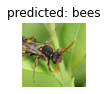

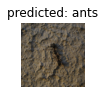

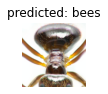

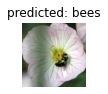

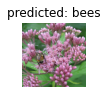

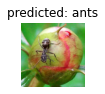

In [16]:
visualize_model(model_ft)

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
---------------
train Loss: 0.7514 Acc: 0.6311
val Loss: 0.6990 Acc: 0.7059

Epoch 1/24
---------------
train Loss: 0.5016 Acc: 0.7828
val Loss: 0.1927 Acc: 0.9281

Epoch 2/24
---------------
train Loss: 0.5160 Acc: 0.7910
val Loss: 0.2211 Acc: 0.9346

Epoch 3/24
---------------
train Loss: 0.4496 Acc: 0.7869
val Loss: 0.1946 Acc: 0.9216

Epoch 4/24
---------------
train Loss: 0.3712 Acc: 0.8197
val Loss: 0.3656 Acc: 0.8627

Epoch 5/24
---------------
train Loss: 0.5187 Acc: 0.7951
val Loss: 0.1795 Acc: 0.9477

Epoch 6/24
---------------
train Loss: 0.5155 Acc: 0.7746
val Loss: 0.2130 Acc: 0.9346

Epoch 7/24
---------------
train Loss: 0.3638 Acc: 0.8238
val Loss: 0.1904 Acc: 0.9477

Epoch 8/24
---------------
train Loss: 0.3135 Acc: 0.8811
val Loss: 0.2131 Acc: 0.9346

Epoch 9/24
---------------
train Loss: 0.2963 Acc: 0.8811
val Loss: 0.2043 Acc: 0.9281

Epoch 10/24
---------------
train Loss: 0.3340 Acc: 0.8566
val Loss: 0.1896 Acc: 0.9477

Epoch 11/24
---------------
tra

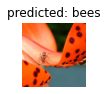

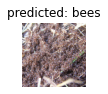

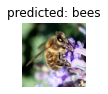

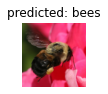

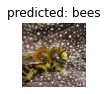

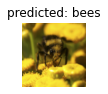

In [22]:
visualize_model(model_conv)

plt.ioff()
plt.show()